# ETH price prediction
## draft: try requests

#interval=
1s
1m
3m
5m
15m
30m
1h
2h
4h
6h
8h
12h
1d
3d
1w
1M

In [1]:
import requests
url = f"https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1h"
r = requests.get(url)
cex_x = r.json()

# cex_x is a list 500 items, one for every hour, on the hour. 
#
# Each item has a list of 12 entries: 
# (0) timestamp (1) open price (2) high price (3) low price (4) close price (5) Vol ..
#
# Example item: [1662998400000, 1706.38, 1717.87, 1693, 1713.56, ..]
# Timestamp is unix time, but in ms. To get unix time (in s), divide by 1000

# Example: get unix timestamps
uts = [xi[0]/1000 for xi in cex_x]

# Example: get close prices
close_prices = [float(xi[4]) for xi in cex_x]

In [5]:
cex_x[0]

[1674504000000,
 '1619.89000000',
 '1635.26000000',
 '1618.65000000',
 '1634.80000000',
 '13128.47390000',
 1674507599999,
 '21335099.58951300',
 21144,
 '6794.68700000',
 '11043952.13451200',
 '0']

In [6]:
cex_x[1]

[1674507600000,
 '1634.80000000',
 '1635.50000000',
 '1629.53000000',
 '1631.84000000',
 '9298.67480000',
 1674511199999,
 '15180018.46912200',
 15686,
 '4916.08620000',
 '8025556.27142700',
 '0']

In [7]:
cex_x[2]

[1674511200000,
 '1631.84000000',
 '1635.75000000',
 '1622.13000000',
 '1627.47000000',
 '8959.69260000',
 1674514799999,
 '14619751.23709700',
 13837,
 '5168.26710000',
 '8435460.34895800',
 '0']

Here's a different example, restricting data to just the previous week.

In [ ]:
from datetime import datetime, timedelta
end_datetime = datetime.now() 
start_datetime = end_datetime - timedelta(days=7)

url = f"https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1h&startTime={int(start_datetime.timestamp())*1000}&endTime={int(end_datetime.timestamp())*1000}"

# the rest is the same. cex_x should have just 168 items (number of hours in the week)

r = requests.get(url)
cex_x_7days = r.json()#168 hours



## Prepare the data
Download and store the recent 2000h data into cex_X_0216.csv

In [12]:
###2.16 17:00 CET
import requests
from datetime import datetime, timedelta
end_datetime = datetime.now() # datetime.datetime(2023, 2, 16, 17, 1, 22, 123888)
start_datetime = end_datetime - timedelta(hours=1000)

url = f"https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1h&startTime={int(start_datetime.timestamp())*1000}&endTime={int(end_datetime.timestamp())*1000}&limit=1000"
r = requests.get(url)
cex_x_1000 = r.json()#1000 hours; from 1000-1999 (1672966800000-1676566799999)


In [13]:
start_datetime2 = start_datetime - timedelta(hours=1000)

url2 = f"https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1h&startTime={int(start_datetime2.timestamp())*1000}&endTime={int(start_datetime.timestamp())*1000}&limit=1000"
r2 = requests.get(url2)
cex_x_2000 = r2.json()#1000 hours; from 0-999 (1669366800000-1672966799999)


In [18]:
cex_x_1000[999]

[1676563200000,
 '1724.14000000',
 '1742.97000000',
 '1723.15000000',
 '1731.97000000',
 '22130.54570000',
 1676566799999,
 '38393312.03019700',
 26088,
 '11100.84330000',
 '19261116.52590600',
 '0']

In [23]:
len(cex_x_1000[999])

12

In [ ]:
#     1499040000000,      // Kline open time
#     "0.01634790",       // Open price
#     "0.80000000",       // High price
#     "0.01575800",       // Low price
#     "0.01577100",       // Close price
#     "148976.11427815",  // Volume
#     1499644799999,      // Kline Close time
#     "2434.19055334",    // Quote asset volume
#     308,                // Number of trades
#     "1756.87402397",    // Taker buy base asset volume
#     "28.46694368",      // Taker buy quote asset volume
#     "0"                 // Unused field, ignore.

In [22]:
cex_X=cex_x_2000+cex_x_1000
len(cex_X)

2000

In [24]:
import pandas as pd
df = pd.DataFrame(cex_X, columns =["Open time", 
                                   "Open price", 
                                   "High price", 
                                   "Low price", 
                                   "Close price", 
                                   "Volume", 
                                   "Close time", 
                                   "Quote asset volume", 
                                   "Number of trades", 
                                   "Taker buy base asset volume", 
                                   "Taker buy quote asset volume", 
                                   "Unused field"])
df.to_csv("./cex_X_0216.csv", encoding="utf_8_sig", index=False)

## Prepare train-test set
Choose features (8); 

Normalization; 

Make X, y, train-test set

In [26]:
### Load csv if you start from here
import pandas as pd
#df=pd.read_csv("./cex_X_0216.csv") 

using_features=["Open price", 
                "High price", 
                "Low price", 
                "Volume", 
                "Quote asset volume", 
                "Number of trades", 
                "Taker buy base asset volume", 
                "Taker buy quote asset volume"]

X_ori=df[using_features].to_numpy()
X_ori.shape
X0_ori=X_ori[:,0].reshape(-1, 1)

(2000, 8)

In [65]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def make_X_y(df, using_features): 
    X_ori=df[using_features].to_numpy()
    scaler=MinMaxScaler(feature_range=(0,1))
    X_scaled=scaler.fit_transform(X_ori)

    X=[]
    y=[]
    for i in range(168, 2000):
        X.append(X_scaled[i-168:i, :])
        y.append(X_scaled[i, 0])
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    
    X_train=X[:1400,:,:]
    X_test=X[1400:,:,:]
    y_train=y[:1400]
    y_test=y[1400:]
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test, scaler

#### Choose 8 features, make train-test set

In [67]:
X_train, X_test, y_train, y_test, scaler=make_X_y(df, using_features)

(1400, 168, 8) (432, 168, 8) (1400, 1) (432, 1)


#### Choose only "Open price" feature, make train-test set

In [66]:
X0_train, X0_test, _, _, scaler_x0=make_X_y(df, ["Open price"])

(1400, 168, 1) (432, 168, 1) (1400, 1) (432, 1)


## Build models & Train

In [69]:
from keras.layers import LSTM, Activation, Dropout, Dense, Input, SimpleRNN
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt


def build_model0(input_shape=(168,8)):
    model=Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1, activation='relu'))
    return model
    
    
def build_model(input_shape=(168,8)):
    X_input = Input(input_shape)

    X = LSTM(32, return_sequences=True)(X_indices)
    X = Dropout(0.6)(X)
    
    X = LSTM(16, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model
    

def train(X_train, y_train, use_model=build_model0, input_shape=(168,8), epochs=10):
    model = use_model(input_shape=input_shape)
    print("train:")
#     adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    model.fit(X_train, y_train, batch_size=32, epochs=epochs)
    return model


#### Use 8 features

In [78]:
#model use 8 features
model=train(X_train, y_train)

train:
Epoch 1/10
1400/1400 [==============================] - 65s 46ms/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 2/10
1400/1400 [==============================] - 57s 41ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 3/10
1400/1400 [==============================] - 58s 41ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 5/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 6/10
1400/1400 [==============================] - 78s 56ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 7/10
1400/1400 [==============================] - 72s 52ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 8/10
1400/1400 [==============================] - 64s 46ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 9/10
1400/1400 [==============================] - 65s 46ms/step - loss: 0.0

In [81]:
model.save('/Users/xyz/Downloads/NL-20/MobiFi/model')

#### Only use "Open price" feature

In [70]:
#model_0 only use "Open price"
model_0=train(X0_train, y_train, input_shape=(168,1))

train:
Epoch 1/10
1400/1400 [==============================] - 67s 48ms/step - loss: 0.0199 - mean_squared_error: 0.0199
Epoch 2/10
1400/1400 [==============================] - 61s 43ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 5/10
1400/1400 [==============================] - 60s 43ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 6/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 7/10
1400/1400 [==============================] - 58s 42ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 8/10
1400/1400 [==============================] - 61s 43ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 9/10
1400/1400 [==============================] - 59s 42ms/step - loss: 0.0

In [82]:
model_0.save('/Users/xyz/Downloads/NL-20/MobiFi/model_0')

## Test
Overall prediction test;

12h sequential prediction test

In [ ]:
#If you start from here, import the trained models
from tensorflow import keras
model = keras.models.load_model('./model')
model_0=keras.models.load_model('./model_0')

In [94]:
def mse_cal(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

#calculate baseline by mean

def baseline_cal(X_test, y_test):
    X0_test=X_test[:,:,0]
#     print(X0_test.shape)
    pred=np.mean(X0_test, axis=1)
#     print(pred.shape)
    y_test_ori=scaler_x0.inverse_transform(y_test)
    pred_ori=scaler_x0.inverse_transform(pred.reshape(-1, 1))
    mse=mse_cal(y_test_ori, pred_ori)
    print("baseline_mse", mse)
    return mse, pred_ori

baseline_mse, baseline_pred=baseline_cal(X_test, y_test)

(432, 168)
(432,)
baseline_mse 3826.9872541659297


In [95]:
def test(model, X_test, y_test, baseline_pred):
    print("test:")
#     mse=model.evaluate(X_test, y_test)[0]
    pred=model.predict(X_test)
    pred=scaler_x0.inverse_transform(pred.reshape(-1, 1))
    y_test=scaler_x0.inverse_transform(y_test.reshape(-1, 1))
    mse=mse_cal(pred, y_test)
    
    plt.plot(pred, c="blue", label="pred")
    plt.plot(y_test, c="red", label="truth")
    plt.plot(baseline_pred, c="black", label="mean", ls='--')
    plt.legend(loc=(1,0.8))
    plt.title("ETH price prediction")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.show()
    #baseline_mse 3826.99
    print("mse:",mse)
    
    return mse


test:


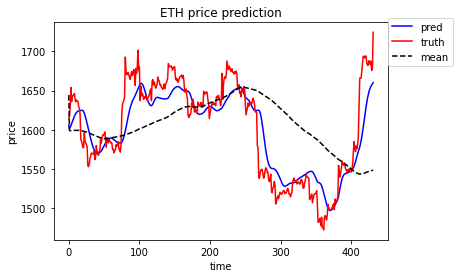

mse: 768.3922896120805


768.3922896120805

In [97]:
#model
test(model, X_test, y_test, baseline_pred)

test:


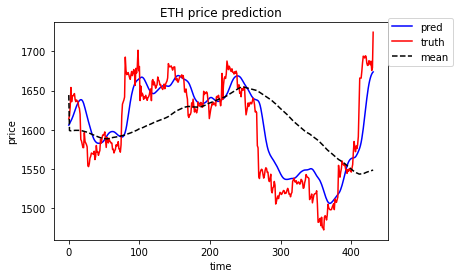

mse: 843.4670357825371


843.4670357825371

In [98]:
#model_0
test(model_0, X0_test, y_test, baseline_pred)

#### Predict one-by-one in sequence

In [87]:
def pred_seq(model,model_0, x_onetest, pred_num=12): 
    out_seq=[]
    x_onetest=x_onetest.reshape(1,168,8)
    pred=model.predict(x_onetest)
    out_seq.append(pred)
#     print(x_onetest.shape)
    xi=x_onetest[0,:,0].reshape(1,168,1)
    
    for i in range(pred_num-1):
        xi[0,:167,0]=xi[0,1:,0]
        xi[0,167:,0]=pred
        pred=model_0.predict(xi)
        out_seq.append(pred)
                
    return out_seq


(1, 168, 8)
mse baseline:  1721.5802449433138
mse:  3059.833727848061


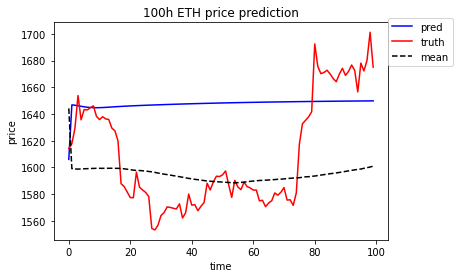

In [102]:
def test_seq(pred_num, model,model_0, X_test, y_test, baseline_pred):
    x_onetest=X_test[0,:,:]
    y_truth=y_test[:pred_num]
    out_seq=pred_seq(model,model_0, x_onetest, pred_num=pred_num)
    out_seq=np.array(out_seq)

    out_seq=scaler_x0.inverse_transform(out_seq.reshape(-1, 1))
    y_truth=scaler_x0.inverse_transform(y_truth.reshape(-1, 1))
    mse=mse_cal(out_seq, y_truth)
    y_mean_slide=baseline_pred[:pred_num]
    mse_baseline=mse_cal(y_mean_slide, y_truth)
    #baseline_mse 
    print("mse baseline: ",mse_baseline)
    print("mse: ",mse)

    plt.plot(out_seq, c="blue", label="pred")
    plt.plot(y_truth, c="red", label="truth")
    plt.plot(baseline_pred[:pred_num], c="black", label="mean", ls='--')
    plt.legend(loc=(1,0.8))
    plt.title(str(pred_num)+"h ETH price prediction")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.show()

test_seq(100, model,model_0, X_test, y_test, baseline_pred)

(1, 168, 8)
mse baseline:  1592.3328161966429
mse:  164.13414219586815


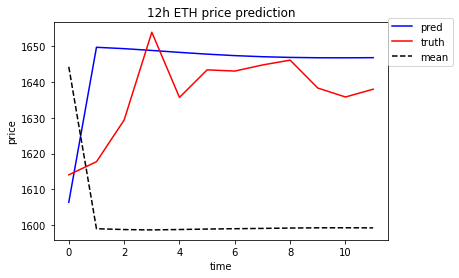

In [103]:
test_seq(12, model,model_0, X_test, y_test, baseline_pred)